# libraries

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import datetime as dt
import json
import requests

# data import

In [2]:
url = 'https://api.binance.com/api/v3/klines'
params = {'symbol': 'BTCUSDT', 'interval': '1d', 'limit': 365}
response = requests.get(url, params=params)
req = json.loads(response.text)

data = pd.DataFrame(req, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume',
                                 'close_time', 'qav', 'trades',
                                 'taker_base_vol', 'taker_quote_vol', 'ignored'])

data.drop(columns=['open', 'high', 'low', 'volume', 'close_time', 'qav', 'trades','taker_base_vol', 'taker_quote_vol', 'ignored'], inplace = True)

data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
data.set_index('timestamp', inplace=True)

data['close'] = data['close'].astype(float)


In [3]:
data.head()

,close
timestamp,
2023-08-13,29303.84
2023-08-14,29430.93
2023-08-15,29200.00
2023-08-16,28730.51
2023-08-17,26623.41


# algo

## sma timeframe

In [4]:
data['10d-ma'] = data['close'].rolling(window=10).mean().shift()
data['20d-ma'] = data['close'].rolling(window=20).mean().shift()
data[9:16]

,close,10d-ma,20d-ma
timestamp,,,
2023-08-22,26056.00,NaN,NaN
2023-08-23,26432.72,27381.561,NaN
2023-08-24,26180.05,27094.449,NaN
2023-08-25,26060.01,26769.361,NaN
2023-08-26,26017.37,26455.362,NaN
2023-08-27,26101.77,26184.048,NaN
2023-08-28,26120.00,26131.884,NaN


## entries

In [5]:
data['signal'] = np.where(data['10d-ma'] > data['20d-ma'], 1, 0)
data['signal'] = np.where(data['10d-ma'] < data['20d-ma'], -1, data['signal'])
data.dropna(inplace=True)

returns

In [6]:
data['return'] = np.log(data['close']).diff()
data['algo_return'] = data['signal'] * data['return']
data['entry'] =  data.signal.diff()

In [7]:
data.head()

,close,10d-ma,20d-ma,signal,return,algo_return,entry
timestamp,,,,,,,
2023-09-02,25869.51,26367.408,26874.4845,-1,NaN,NaN,NaN
2023-09-03,25971.21,26311.087,26702.7680,-1,0.003924,-0.003924,0.0
2023-09-04,25826.02,26290.203,26529.7820,-1,-0.005606,0.005606,0.0
2023-09-05,25792.10,26266.804,26361.0830,-1,-0.001314,0.001314,0.0
2023-09-06,25759.95,26244.277,26214.1625,1,-0.001247,-0.001247,2.0


# ploting entries and performances

## entries -

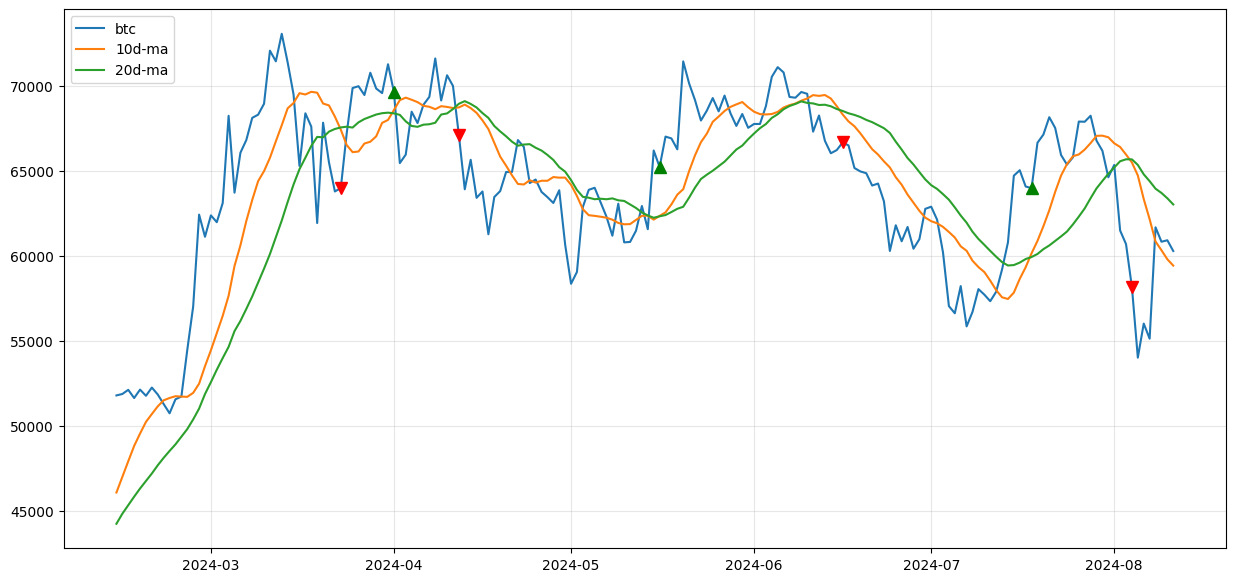

In [8]:
plt.rcParams['figure.figsize'] = 15, 7
plt.grid(True, alpha = .3)
plt.plot(data.iloc[-180:]['close'], label = 'btc')
plt.plot(data.iloc[-180:]['10d-ma'], label = '10d-ma')
plt.plot(data.iloc[-180:]['20d-ma'], label = '20d-ma')
plt.plot(data[-180:].loc[data.entry == 2].index, data[-180:]['close'][data.entry == 2], '^',
         color = 'g', markersize = 8)
plt.plot(data[-180:].loc[data.entry == -2].index, data[-180:]['close'][data.entry == -2], 'v',
         color = 'r', markersize = 8)
plt.legend(loc=2);

## performance

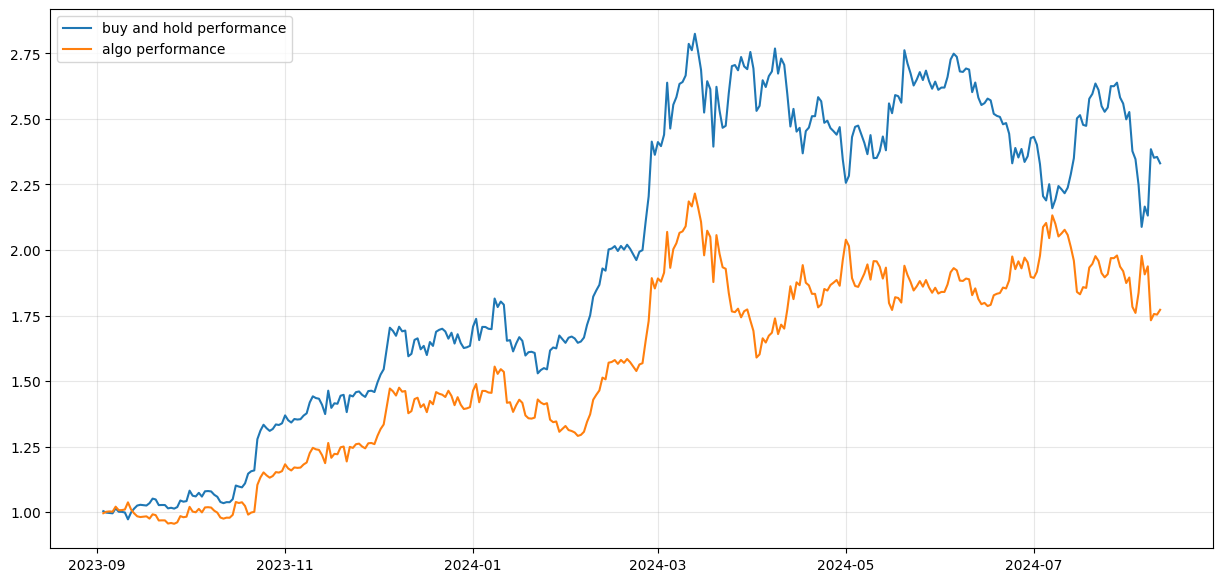

In [9]:
plt.plot(np.exp(data['return']).cumprod(), label='buy and hold performance')
plt.plot(np.exp(data['algo_return']).cumprod(), label='algo performance')
plt.legend(loc=2)
plt.grid(True, alpha=.3)

# returns

## buy n hold (%)

In [10]:
(np.exp(data['return']).cumprod()[-1] - 1) *100   #[-1] -> last day of returns

C:\Users\cristopher\AppData\Local\Temp\ipykernel_20776\2914727324.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (np.exp(data['return']).cumprod()[-1] - 1) *100   #[-1] -> last day of returns


133.05814451066112

## system (%)

In [12]:
(np.exp(data['algo_return']).cumprod()[-1] - 1) *100

C:\Users\cristopher\AppData\Local\Temp\ipykernel_20776\4162292452.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (np.exp(data['algo_return']).cumprod()[-1] - 1) *100


77.1941216355166